In [50]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
from sklearn.metrics import mean_absolute_error

import proxima_analysis as pa

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

In [51]:
experiments = [
    "NORT-Proxima_dynamicalpha", #Proxima - dynamic alpha with no retrain interval
    "NORT-Proxima_static-alpha", #Proxima - precalcualted alpha, no retrain interval
    "surrogate_only", ## Simple surrogate implementation
    "SS-UQ02-NORT_staticalpha", # Simple surrogate, uq:0.2, no retrain interval
    "DA_RT50", ## Proxima - dynamica alpha, testing single RT interval of 50 
    "DAallUQ_TEMP1000", ## Proxima - testing different retrain intervals and UQ's
    "SST1000_bestparameters", ## Simple surrogate - with different Retrain intervals tested
    "SS_RI300", ## Simple Surrogate with RI 300
    "SS-UQ02_I50", ## Simple surrogate, uq: 0.2, All temps, RI: 50
    "SS-UQall_I50", ## Simple surrogate,, all UQ, Temp: 500, RI: 50
    "surrogate-all_params", ## Simple surrogate, all uq, all temps, RI: 1,50, 100,500
    "dyn_nostreak", ##Proxima - dynamic alpha, no surrogate streak option

]
root_path = "../proxima_data"

## Loading HF Results

In [52]:
#root_path_hf = "/home/yzamora/proxima/examples/molecule-sampling"
path_str = "/".join([root_path,"runtime_s1_data.csv"])
hf_times = pd.read_csv(path_str)
float(hf_times.set_index('Temp[K]').loc[100])

516.6875301501714

## Graphing HF time against temperature

In [54]:
hf_times

Temp[K]  Runtime[s]
0      100  516.687530
1      200  523.776283
2      300  532.178107
3      400  528.386581
4      500  529.334293
5      600  519.650676
6      700  522.845046
7      800  518.376097
8      900  601.335490
9     1000  531.075613

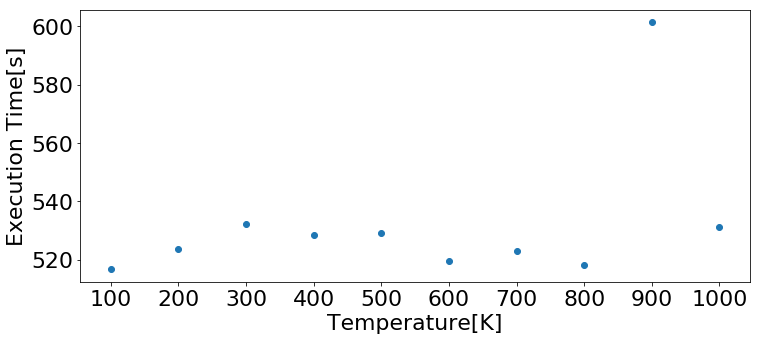

In [65]:
plt.subplots(figsize=(12,5))
plt.plot(hf_times['Temp[K]'],hf_times['Runtime[s]'],'o')

plt.xlabel('Temperature[K]')
plt.ylabel('Execution Time[s]')
plt.xticks(hf_times['Temp[K]'])
plt.savefig('Figures/TF_times.png')

## Combining results into results dictionary 

In [32]:
results = {n: None for n in experiments}
for name in results:
    path_str = "/".join([root_path, name, "*"])
    path = glob.glob(path_str)
    import pdb;
    
    uq_thresholds, int_list, total_time, uq_time = pa.process_times(path)
    time_df = pa.time_to_df(uq_time)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")

In [33]:
results.keys()

dict_keys(['NORT-Proxima_dynamicalpha', 'NORT-Proxima_static-alpha', 'surrogate_only', 'SS-UQ02-NORT_staticalpha', 'DA_RT50', 'DAallUQ_TEMP1000', 'SST1000_bestparameters', 'SS_RI300', 'SS-UQ02_I50', 'SS-UQall_I50', 'surrogate-all_params', 'dyn_nostreak'])

## Graphing MAE VS Time results of surrogate implementation

In [15]:
def _plot_cases(cases): #df_a, df_b, df_c, df_d):
    fig, ax = plt.subplots(figsize=(12,5))
    for case in cases:
        df = case.get("df")
        x = case.get("x")
        y = case.get("y")
        color = case.get("color", "Black")
        label = case.get("label", None)
        marker = case.get("marker", "o")
        s = case.get("s", 30)
        df.plot.scatter(x=x, y=y, color=color, label=label, marker=marker, s=s, ax=ax)

    #ax.set_ylim([0.0, 0.007])
    ax.set_ylim([0.0, 0.009])
    ax.set_xscale("log")
    ax.ticklabel_format(axis='y',style='scientific',scilimits=(0,0))
    ax.axvline(x=523.21)#,ymin=0,ymax=0.002) #Average hf runtime
    ax.axhline(y=0.002)
    plt.xlabel('Execution Time')
    plt.ylabel("Mean Absolute Error")
    plt.tight_layout()
    #plt.title('Implementation Results')


In [45]:
results['dyn_nostreak']

uq  interval     time  temperature       mae
0  0.5         1  101.772          100  0.000618
1  0.5         1  345.726         1000  0.001597
2  0.5         1  118.750          200  0.000821
3  0.5         1  138.574          300  0.001582
4  0.5         1  152.177          400  0.001438
5  0.5         1  284.501          500  0.001550
6  0.5         1  150.387          600  0.001524
7  0.5         1  319.277          700  0.001678
8  0.5         1  316.106          800  0.001627
9  0.5         1  560.276          900  0.001466

# Simple Surrogate Implementation
Results of tests with 
uq = 01.-0.7,
Temp=500
Retrain interval = 1,2,5-45(in intervals of 5)
Extreme RI 100-500

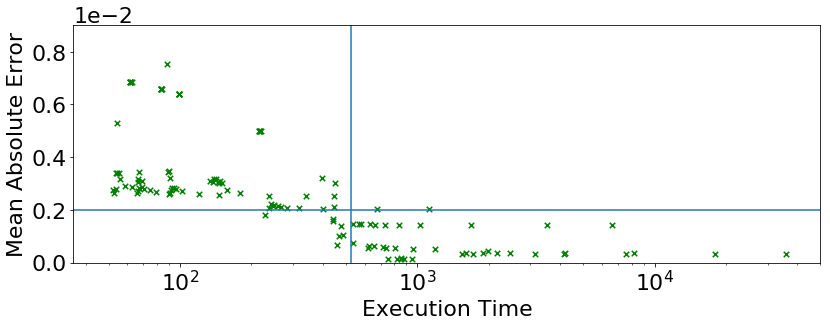

In [37]:
cases = (
        {"df": results['surrogate-all_params'], "x":"time", "y":"mae", "color":'Green', "marker":"x"},
    )
_plot_cases(cases)
plt.savefig('Figures/ss_extremeparams.png')

## Simple Surrogate
Only retrain intervals from 1- 50

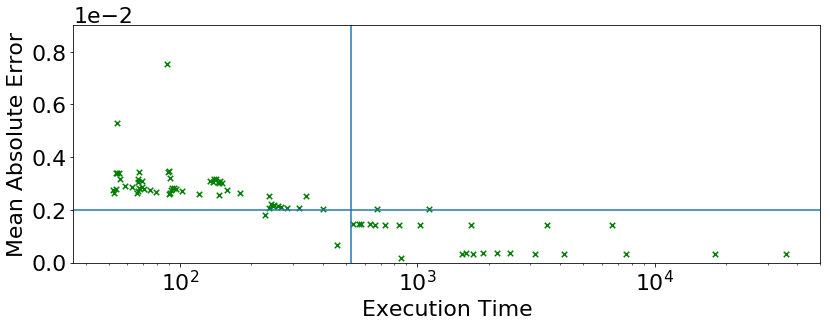

In [38]:
cases = (
        {"df": results['surrogate_only'], "x":"time", "y":"mae", "color":'Green', "marker":"x"},
    )
_plot_cases(cases)
plt.savefig('Figures/ss_allparams.png')

## Looking through all surrogate parameters

In [39]:
"""bs = results['SST1000_bestparameters']
bs[bs['interval']==400]
bs[bs['mae']<0.002]"""

"bs = results['SST1000_bestparameters']\nbs[bs['interval']==400]\nbs[bs['mae']<0.002]"

## SS implementation - No Retrain Interval
UQ=0.2 No retraining interval

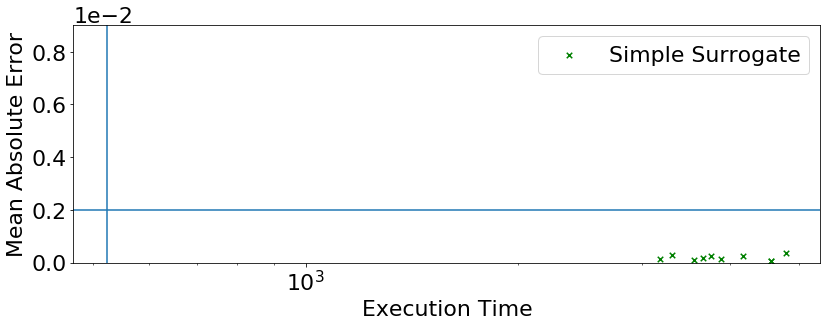

In [40]:
cases = (
        {"df": results['SS-UQ02-NORT_staticalpha'], "x":"time", "y":"mae", "color":'Green', "label":'Simple Surrogate', "marker":"x"},
    )
_plot_cases(cases)
plt.savefig('Figures/ss_nort.png')

# Simple Surrogate Implementation VS Proxima -- NO RI
Results of tests with 
uq = 0.2
Retrain interval = No retrain interval specified

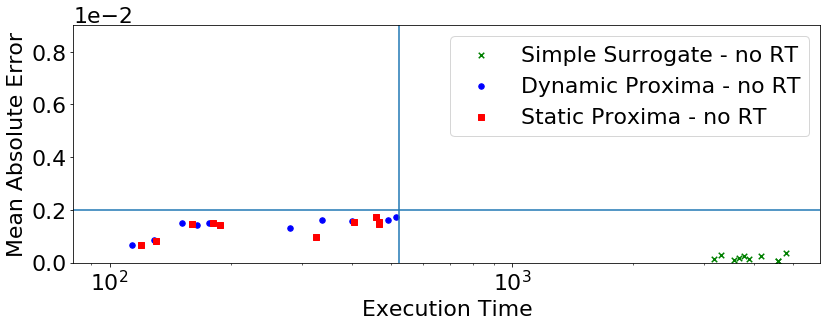

In [41]:
cases = (
        {"df": results["SS-UQ02-NORT_staticalpha"], "x":"time", "y":"mae", "color":'Green', "label":'Simple Surrogate - no RT', "marker":"x"},
        {"df": results['NORT-Proxima_dynamicalpha'], "x":"time", "y":"mae", "color":'Blue', "label":'Dynamic Proxima - no RT', "marker":"o"},
        {"df": results['NORT-Proxima_static-alpha'], "x":"time", "y":"mae", "color":'REd', "label":'Static Proxima - no RT', "marker":"s"},
    )
_plot_cases(cases)
plt.savefig('Figures/no_retrain.png')

## Simple Surrogate Implementation, best parameters- RI = 300
Results of tests with uq = 0.2 Retrain interval = 300

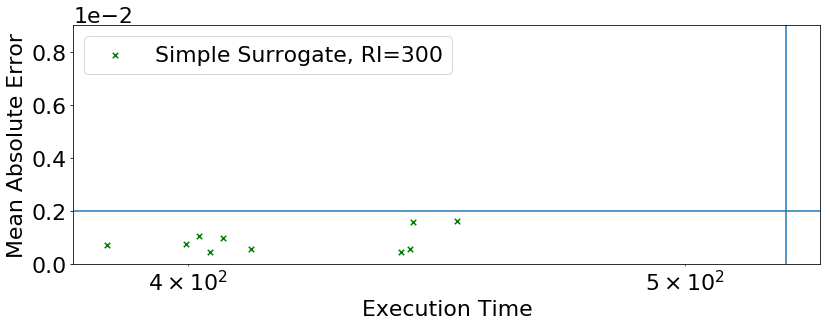

In [42]:
cases = (
        {"df": results["SS_RI300"], "x":"time", "y":"mae", "color":'Green', "label":'Simple Surrogate, RI=300', "marker":"x"},
    )
_plot_cases(cases)
plt.savefig('Figures/ss_ri300.png')

## SS best parameters, RI=300 VS Proxima dynamic and static
UQ=0.2, RI=300

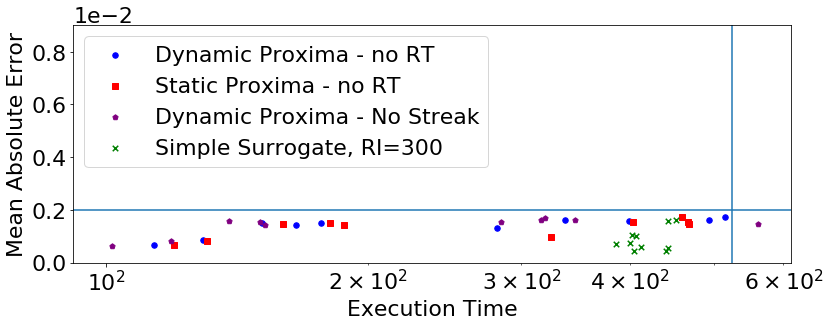

In [44]:
cases = (
        {"df": results['NORT-Proxima_dynamicalpha'], "x":"time", "y":"mae", "color":'Blue', "label":'Dynamic Proxima - no RT', "marker":"o"},
        {"df": results['NORT-Proxima_static-alpha'], "x":"time", "y":"mae", "color":'Red', "label":'Static Proxima - no RT', "marker":"s"},
        {"df": results['dyn_nostreak'], "x":"time", "y":"mae", "color":'Purple', "label":'Dynamic Proxima - No Streak', "marker":"p"},
        {"df": results['SS_RI300'], "x":"time", "y":"mae", "color":'Green', "label":'Simple Surrogate, RI=300', "marker":"x"},
    )
_plot_cases(cases)
plt.savefig('Figures/ThreeProx_scatter.png')

# Plotting other comparisons

## Dynamic VS Static VS Simple Surrogate 
No retrain interval for Proxima implementations 

Simple surrogate implementation results are of all UQ and RI combinations

'NORT-Proxima_dynamicalpha', 'NORT-Proxima_static-alpha', 'surrogate_only'

All temperatures for Proxima - 500K for surrogate

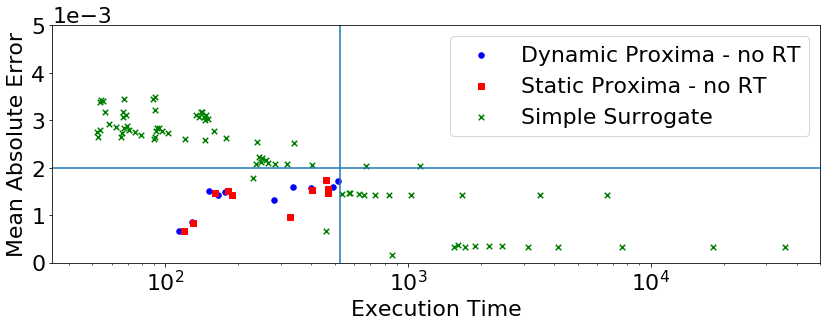

In [129]:
cases = (
        {"df": results['NORT-Proxima_dynamicalpha'], "x":"time", "y":"mae", "color":'Blue', "label":'Dynamic Proxima - no RT', "marker":"o"},
        {"df": results['NORT-Proxima_static-alpha'], "x":"time", "y":"mae", "color":'REd', "label":'Static Proxima - no RT', "marker":"s"},
        {"df": results['surrogate_only'], "x":"time", "y":"mae", "color":'Green', "label":'Simple Surrogate', "marker":"x"},
    )
_plot_cases(cases)

## No retrain interval comparison - Tests across all temperatures
No retrain interval used on all methods
UQ = 0.2 for simple surrogate to keep under MAE for all temperatures
Temperatures of 100 - 1000K, in increments of 100 tested 

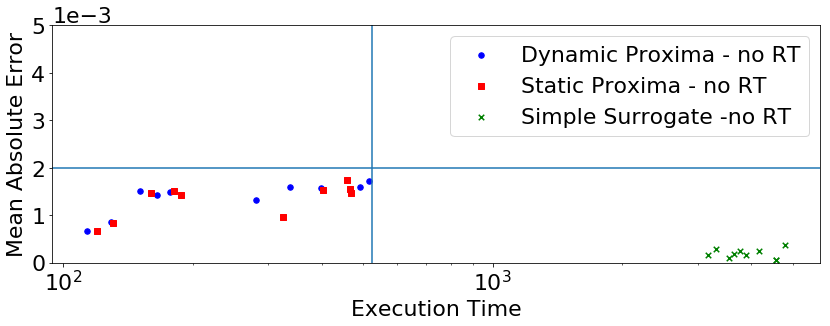

In [130]:
cases = (
        {"df": results['NORT-Proxima_dynamicalpha'], "x":"time", "y":"mae", "color":'Blue', "label":'Dynamic Proxima - no RT', "marker":"o"},
        {"df": results['NORT-Proxima_static-alpha'], "x":"time", "y":"mae", "color":'REd', "label":'Static Proxima - no RT', "marker":"s"},
        {"df": results['SS-UQ02-NORT_staticalpha'], "x":"time", "y":"mae", "color":'Green', "label":'Simple Surrogate -no RT', "marker":"x"},
    )
_plot_cases(cases)

## Comparing Proxima implementations
Using Retrain Interval VS predetermined retrain interval

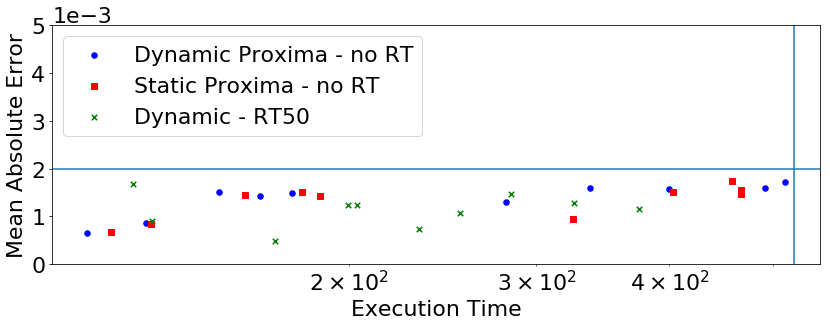

In [132]:

cases = (
        {"df": results['NORT-Proxima_dynamicalpha'], "x":"time", "y":"mae", "color":'Blue', "label":'Dynamic Proxima - no RT', "marker":"o"},
        {"df": results['NORT-Proxima_static-alpha'], "x":"time", "y":"mae", "color":'Red', "label":'Static Proxima - no RT', "marker":"s"},
        {"df": results['DA_RT50'], "x":"time", "y":"mae", "color":'Green', "label":'Dynamic - RT50', "marker":"x"},
    )
_plot_cases(cases)

## Dynamic Proxima compared with simple surrogate with RI 300

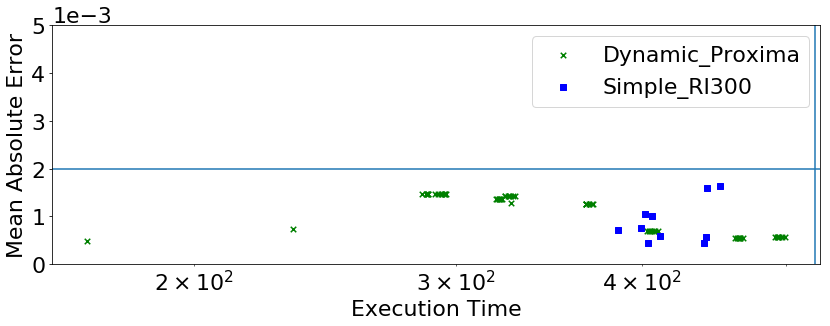

In [133]:
cases = (
        {"df": results['DAallUQ_TEMP1000'], "x":"time", "y":"mae", "color":'Green', "label":'Dynamic_Proxima', "marker":"x"},
        {"df": results['SS_RI300'], "x":"time", "y":"mae", "color":'Blue', "label":'Simple_RI300', "marker":"s"},
    )
_plot_cases(cases)

## Mixed results  - Dynamic Proxima compared with simple surrogate
Dyanamic proxima is run using constant temperature (1,000K)

UQ = 0.1 - 0.7
Retrain Interval = 1,2,5-45,increments of 5
And Retrain Intervals = 100-500, increments of 50

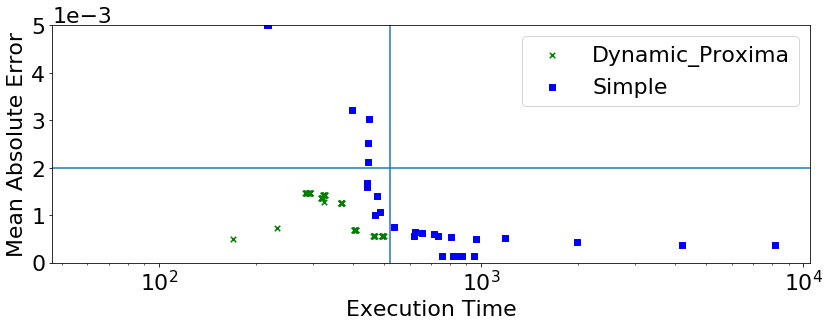

In [134]:
cases = (
        {"df": results['DAallUQ_TEMP1000'], "x":"time", "y":"mae", "color":'Green', "label":'Dynamic_Proxima', "marker":"x"},
        {"df": results['SST1000_bestparameters'], "x":"time", "y":"mae", "color":'Blue', "label":'Simple', "marker":"s"},
    )
_plot_cases(cases)